# Mock Challenge Level 0 --- `provabgs` mocks without noise

In [1]:
import os
import numpy as np 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
#    mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
import gqp_mc.util as UT

In [3]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import corrprior as Corrprior

/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:25: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [4]:
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

# read mock spectra

In [5]:
wave_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.wave.npy')
theta_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.theta.npy')
flux_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.flux.npy')
z_obs = 0.2

In [6]:
unt_theta_obs = prior.untransform(theta_obs)

In [7]:
m_nmf = Models.NMF(burst=True, emulator=True)

(3000.0, 10000.0)

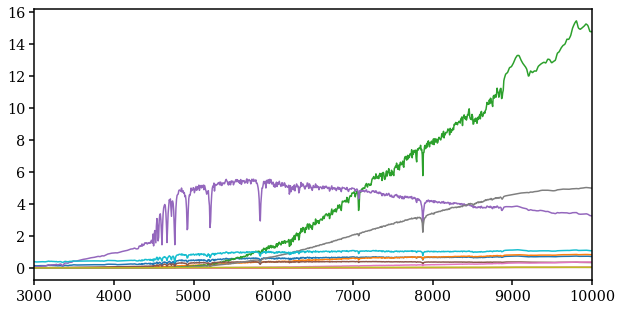

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for f in flux_obs[:10]: sub.plot(wave_obs, f)
sub.set_xlim(3e3, 1e4)

# load in MCMC chains that were run on cori

In [9]:
desi_mcmc = Infer.desiMCMC(model=m_nmf, prior=prior)

In [10]:
chain_dir = os.path.join(UT.dat_dir(), 'mini_mocha', 'provabgs_mocks')
f_chain = lambda i: os.path.join(chain_dir, 'provabgs_mock.%i.chain.npy' % i)

In [11]:
chains = [] 
for i in range(100): 
    chains.append(np.load(f_chain(i)))

Some quick sanity checks on the fits and the chains' convergence

/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:849: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:908: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:849: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:908: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])


[1.01390127e+01 3.91571329e-01 9.02925829e-01 5.26697840e-01
 3.40199486e-01 6.88412113e+00 3.29431210e-03 1.93145680e-03
 8.05072701e-01 1.18940177e+00 2.30787999e-01]
-4.73326172782329e-30
[ 9.93041254e+00  6.87279259e-01  7.48231324e-01  3.98169587e-01
  1.22256995e-01  6.62481547e+00  3.64596274e-03  3.92064895e-03
  8.90622671e-02  1.11176948e+00 -5.60270231e-01]
-0.09389060666338597
[ 1.01411885e+01  1.91344665e-01  1.74655028e-01  9.15617735e-01
  8.00960900e-01  7.92339993e+00  4.32473759e-03  8.30121109e-04
  2.09031622e+00  1.03557692e+00 -1.20725626e+00]
0.0
[ 1.00918023e+01  2.81918822e-01  2.22160981e-01  2.45111232e-01
  8.45490163e-01  7.25616164e+00  1.35705690e-03  2.91902908e-03
  1.19631747e+00  8.88098464e-01 -1.51448419e+00]
-0.015541733367142157


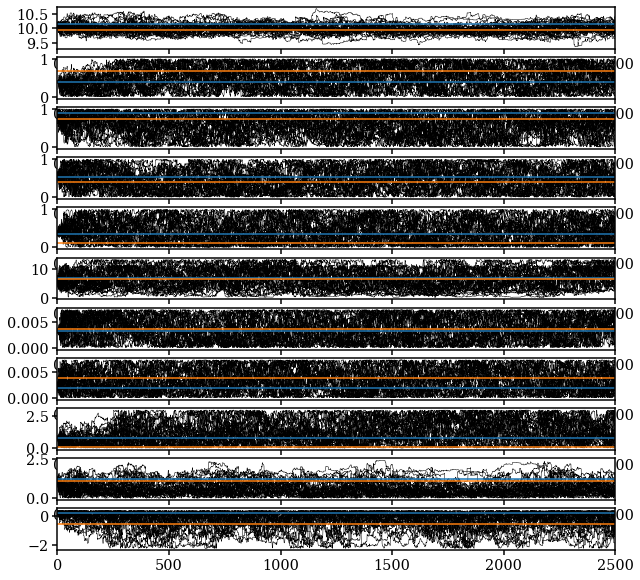

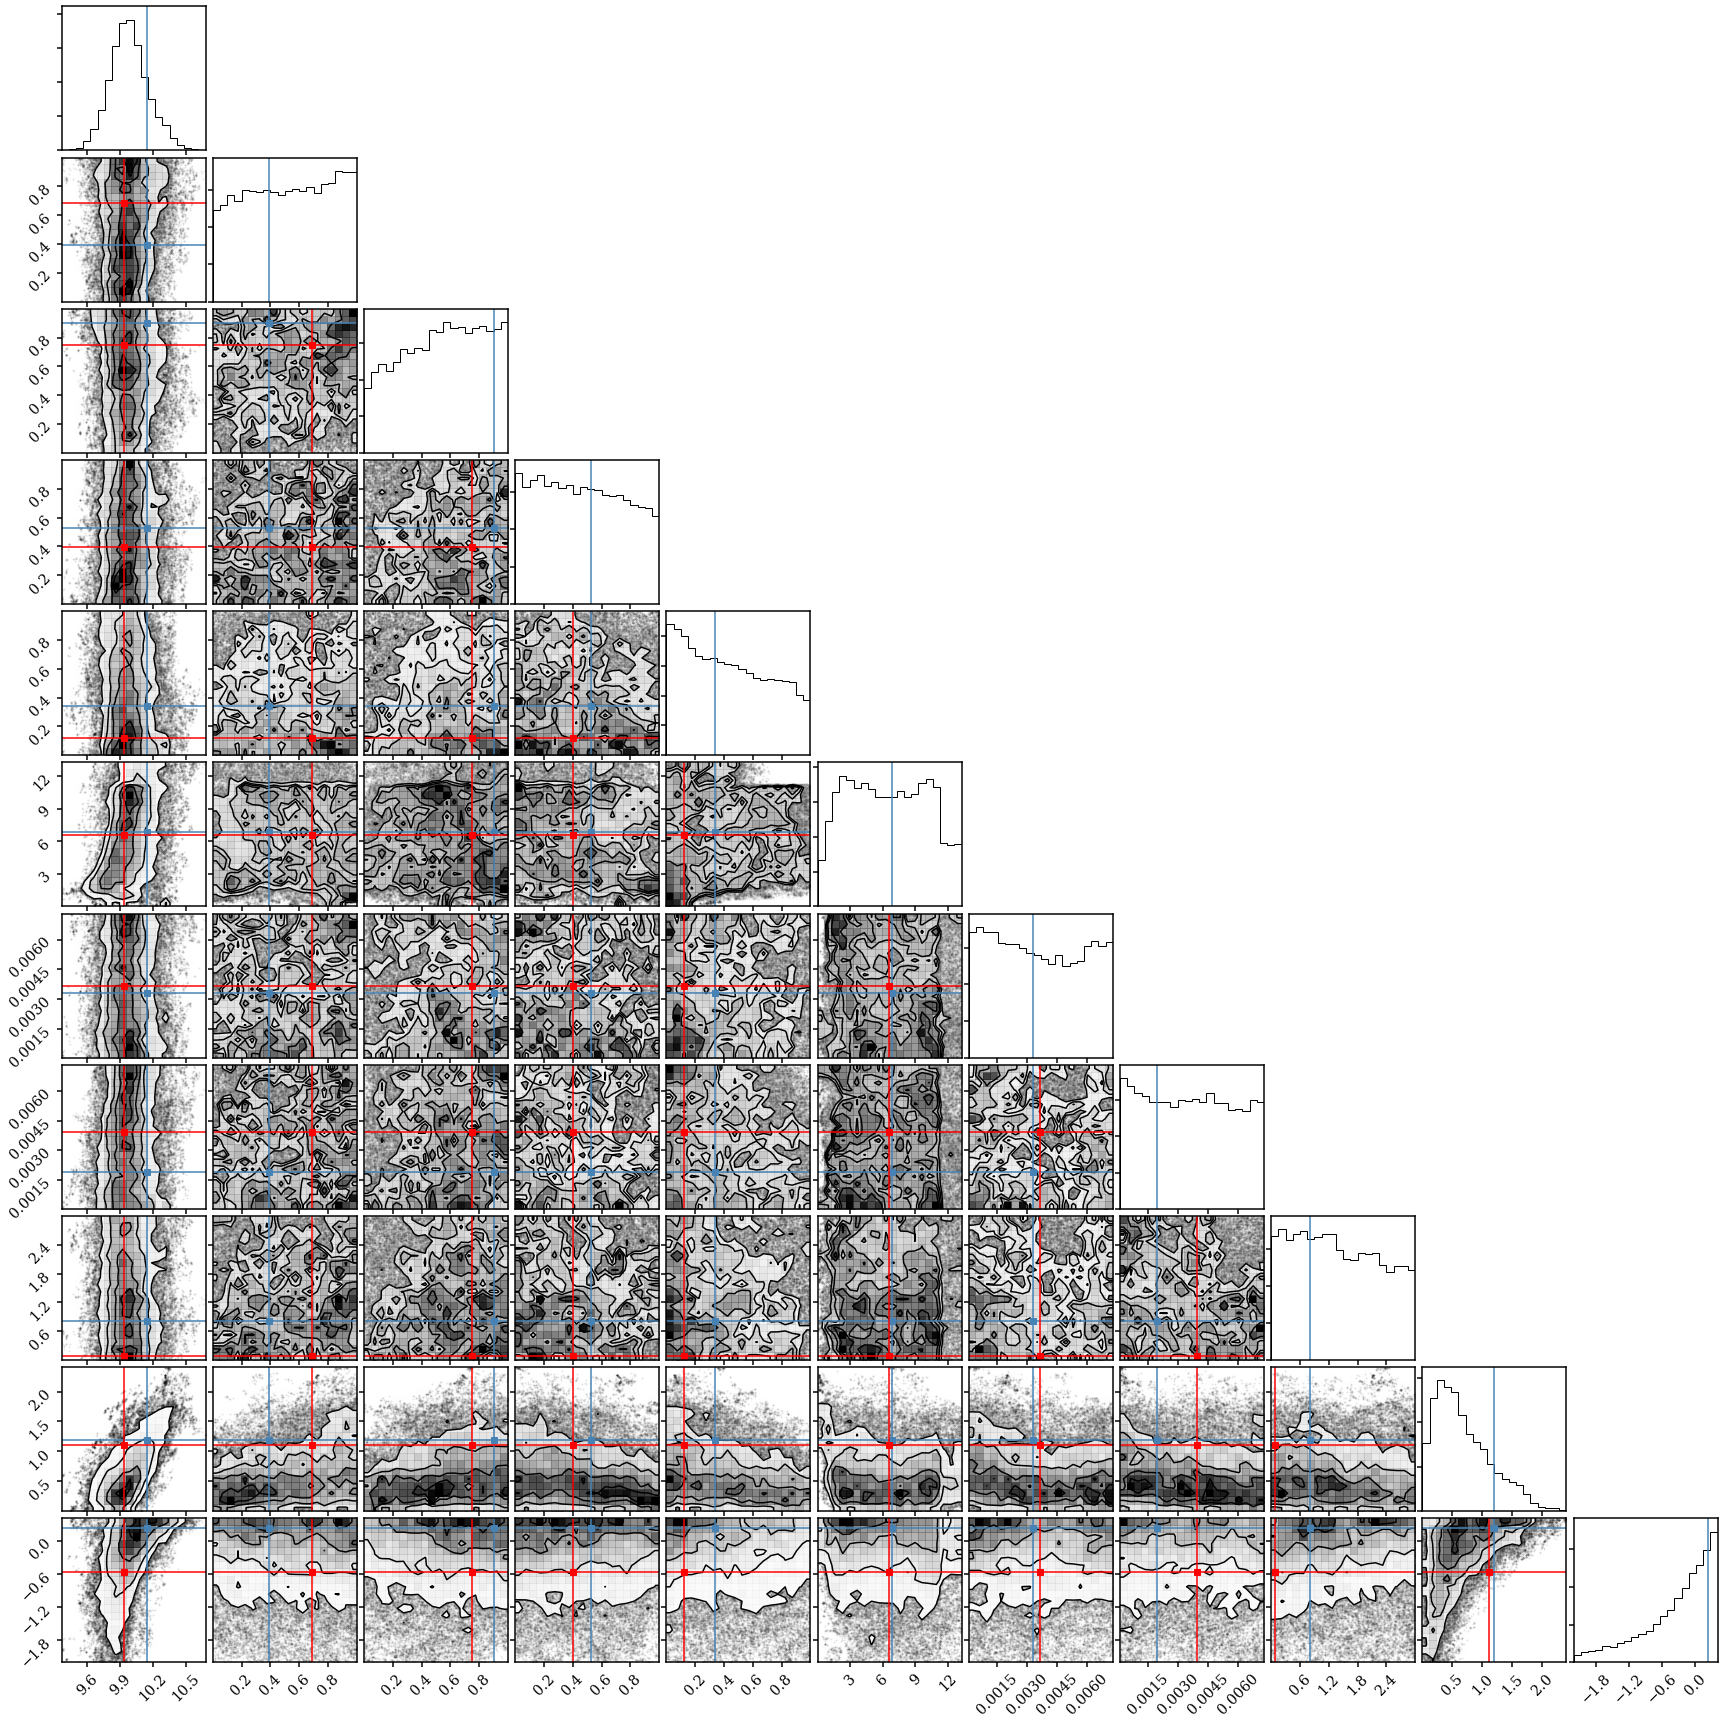

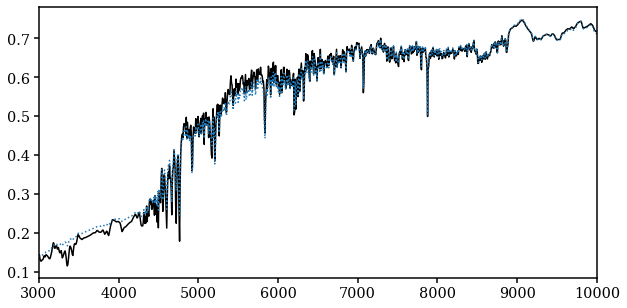

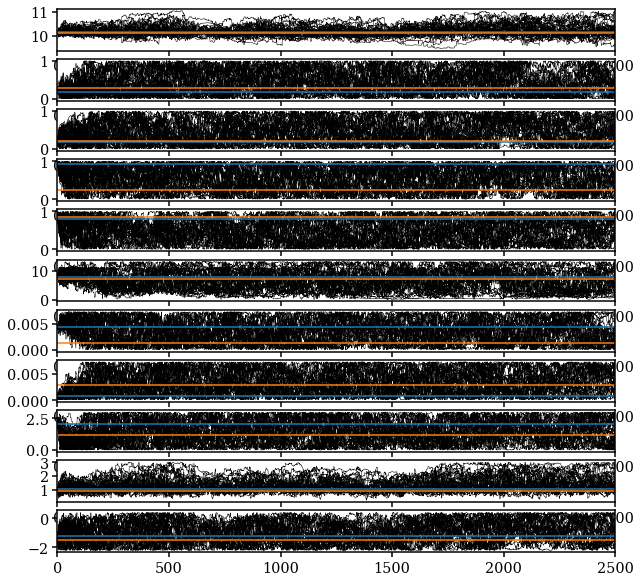

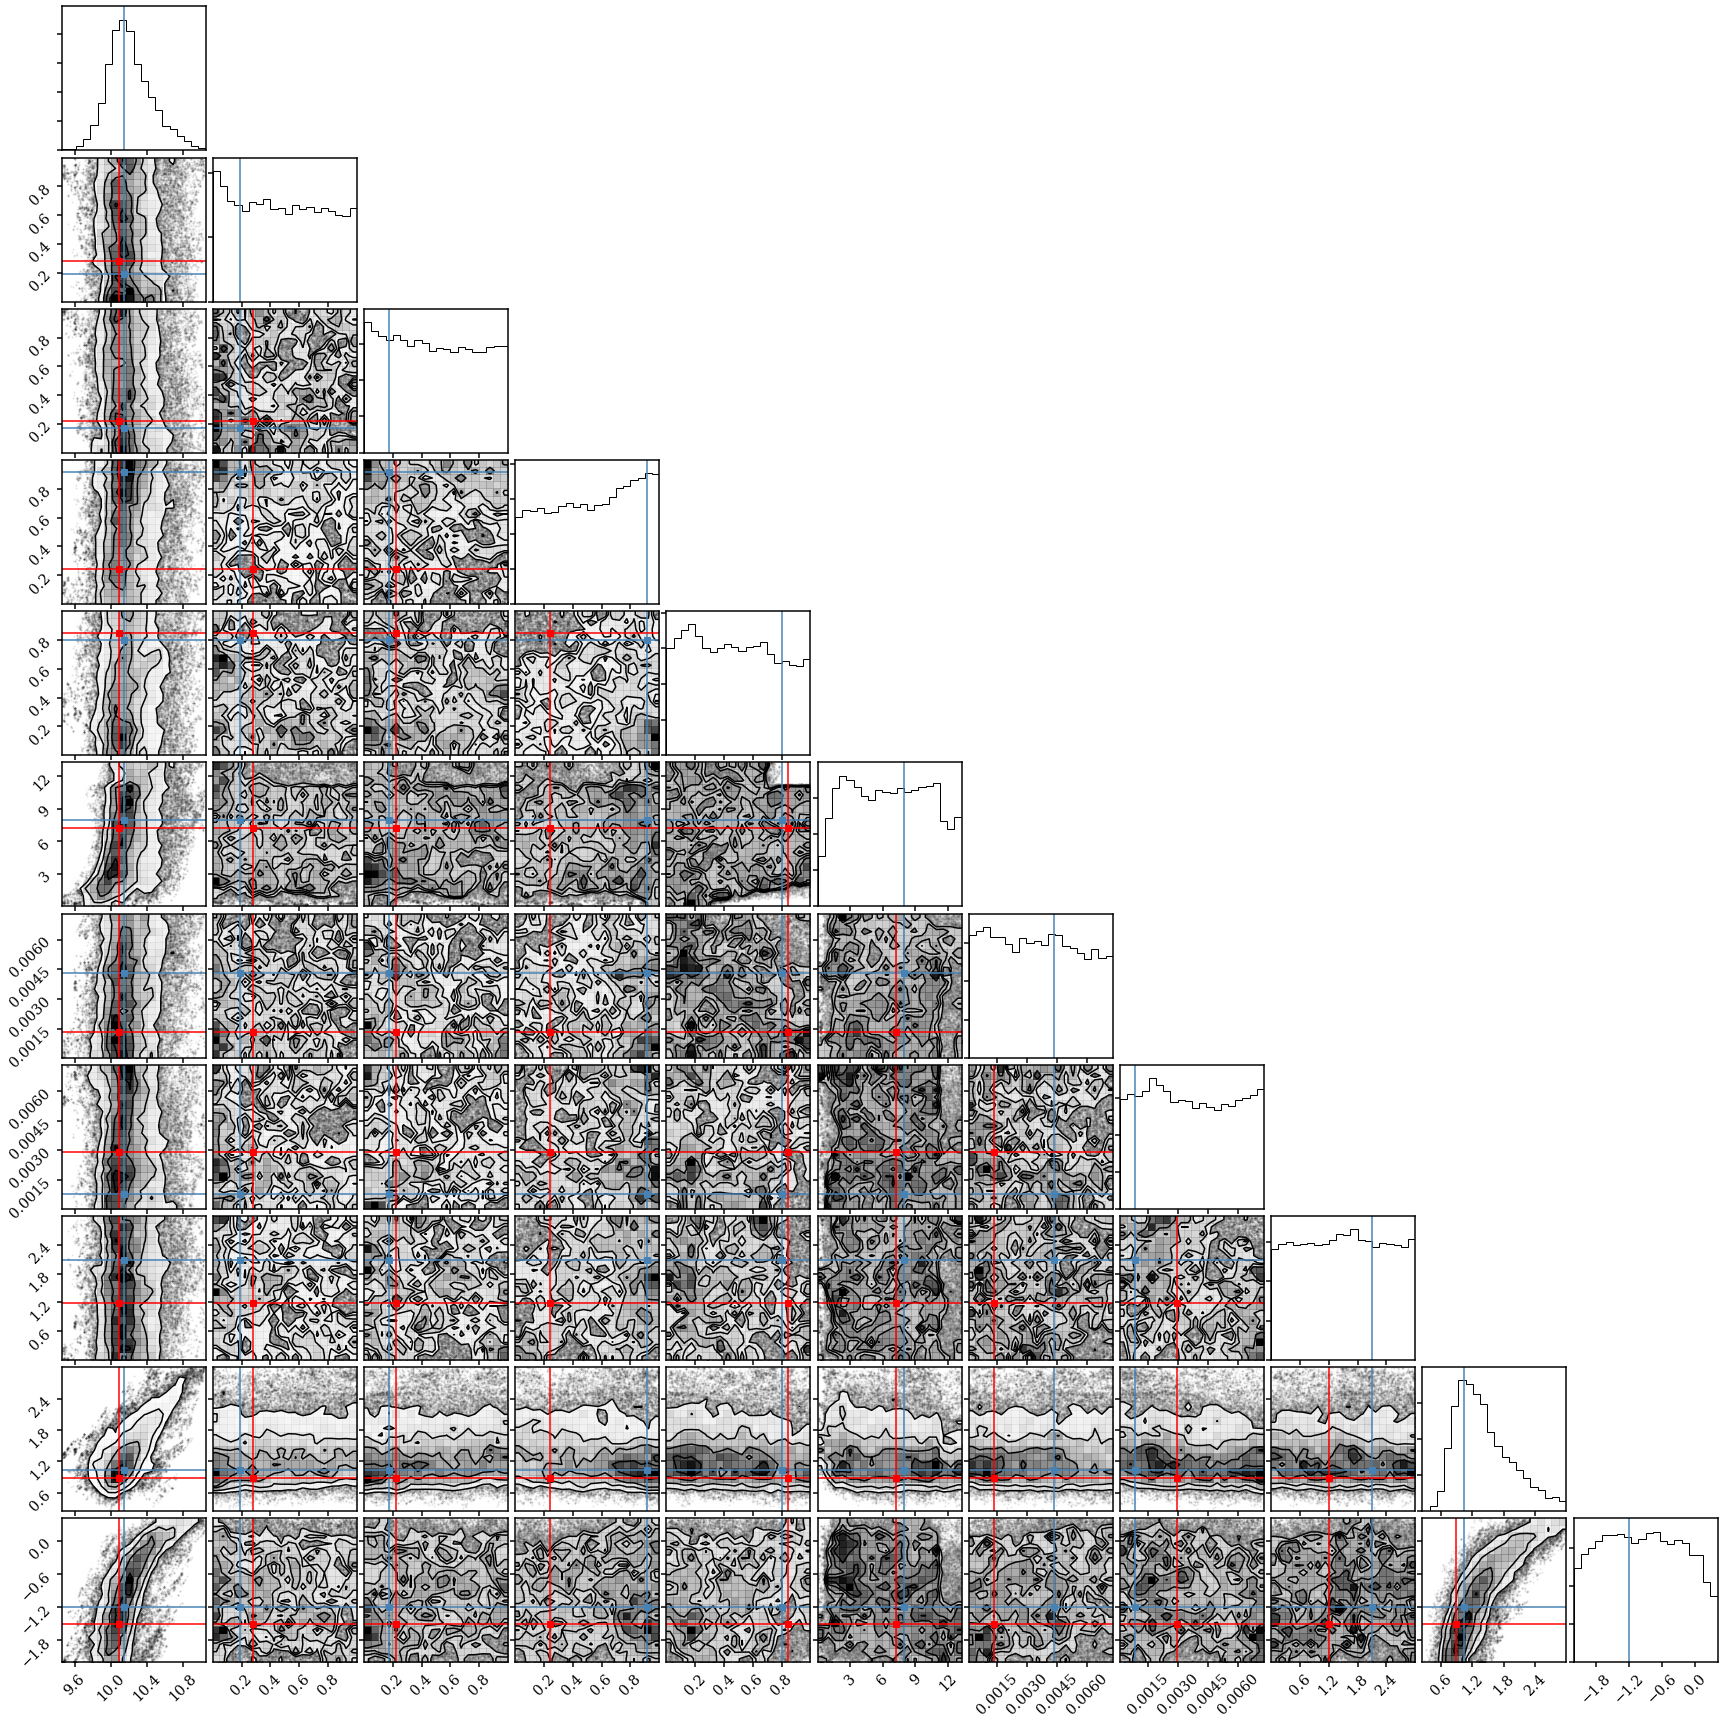

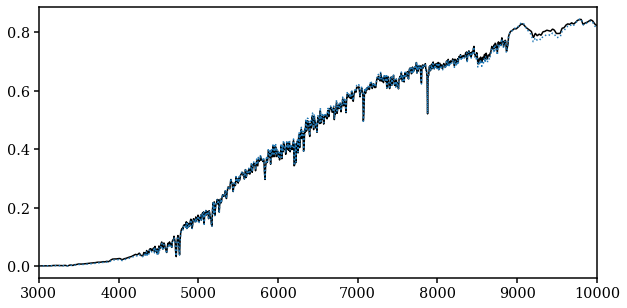

In [12]:
for i, chain in enumerate(chains[:2]): 
    flat_chain = desi_mcmc._flatten_chain(chain[500:,:,:])    
    unt_chain = prior.untransform(flat_chain)
    
    args, kwargs = desi_mcmc._lnPost_args_kwargs(
        wave_obs=wave_obs, 
        flux_obs=flux_obs[i], 
        flux_ivar_obs=np.ones(len(wave_obs)), 
        zred=z_obs, 
        vdisp=0
    )
    tts, lnPs = [], []
    for tt in unt_chain[::100]: 
        tts.append(tt)
        lnPs.append(desi_mcmc.lnPost(tt, *args, **kwargs))
    unt_theta_bf = tts[np.argmax(lnPs)]
    unt_theta_median = np.median(unt_chain, axis=0)
    
    print(unt_theta_obs[i])
    print(desi_mcmc.lnPost(unt_theta_obs[i], *args, **kwargs))
    print(unt_theta_bf)
    print(np.max(lnPs))

    unt_theta_bf = tts[np.argmax(lnPs)]
    
    fig = plt.figure(figsize=(10, 10))
    for ii in range(theta_obs.shape[1]-1): 
        sub = fig.add_subplot(theta_obs.shape[1]-1, 1, ii+1)
        for j in range(30): 
            unt_chain_i = desi_mcmc.prior.untransform(chain[:,j,:])
            sub.plot(unt_chain_i[:,ii], c='k', lw=0.5)
        sub.axhline(unt_theta_obs[i][ii], color='C0')
        sub.axhline(unt_theta_bf[ii], color='C1')
        sub.set_xlim(0,2500)
    
    fig = DFM.corner(unt_chain, truths=unt_theta_obs[i])
    
    axes = np.array(fig.axes).reshape((unt_theta_obs.shape[1], unt_theta_obs.shape[1]))

    # Loop over the histograms
    for yi in range(unt_theta_obs.shape[1]):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(unt_theta_bf[xi], color="r")
            ax.axhline(unt_theta_bf[yi], color="r")
            ax.plot(unt_theta_bf[xi], unt_theta_bf[yi], "sr")
            
    _, flux_model_bf = m_nmf.sed(desi_mcmc.prior.transform(unt_theta_bf), z_obs, wavelength=wave_obs)
    
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(wave_obs, flux_obs[i], c='k')
    sub.plot(wave_obs, flux_model_bf, ls=':')
    sub.set_xlim(3e3, 1e4)    

Things look pretty reasonable. Now let's calculate derived quantities --- physical galaxy properties

In [18]:
flat_chains = []
logMstar_true, logMstar_inf = [], [] 
logSSFR_true, logSSFR_inf = [], [] 
logZ_MW_true, logZ_MW_inf = [], []

for i, chain in enumerate(chains): 
    flat_chain = desi_mcmc._flatten_chain(chain[500:,:,:])       
    flat_chains.append(flat_chain)
    
    logMstar_true.append(theta_obs[i][0])
    logMstar_inf.append(flat_chain[:,0])
    
    logSSFR_true.append(np.log10(m_nmf.avgSFR(theta_obs[i], z_obs, dt=1.0)) - theta_obs[i][0])
    logSSFR_inf.append(np.log10(m_nmf.avgSFR(flat_chain, z_obs, dt=1.0)) - flat_chain[:,0])
    
    logZ_MW_true.append(np.log10(m_nmf.Z_MW(theta_obs[i], m_nmf.cosmo.age(z_obs).value)))
    logZ_MW_inf.append(np.log10(m_nmf.Z_MW(flat_chain, m_nmf.cosmo.age(z_obs).value)))
    
flat_chains = np.array(flat_chains)

logMstar_true = np.array(logMstar_true)
logMstar_inf = np.array(logMstar_inf)

logSSFR_true = np.array(logSSFR_true).flatten()
logSSFR_inf = np.array(logSSFR_inf)

logZ_MW_true = np.array(logZ_MW_true).flatten()
logZ_MW_inf = np.array(logZ_MW_inf)

# dust parameters
dust1_true = np.array([theta_obs[i][-3] for i in range(100)])
dust1_inf = np.array([flat_chain[:,-3] for flat_chain in flat_chains])

dust2_true = np.array([theta_obs[i][-2] for i in range(100)])
dust2_inf = np.array([flat_chain[:,-2] for flat_chain in flat_chains])

dust_index_true = np.array([theta_obs[i][-1] for i in range(100)])
dust_index_inf = np.array([flat_chain[:,-1] for flat_chain in flat_chains])

Lets take a look at the posterior on the galaxy properties: $\log M_*$, $\log~{\rm SSFR}$, and $Z_{\rm MW}$

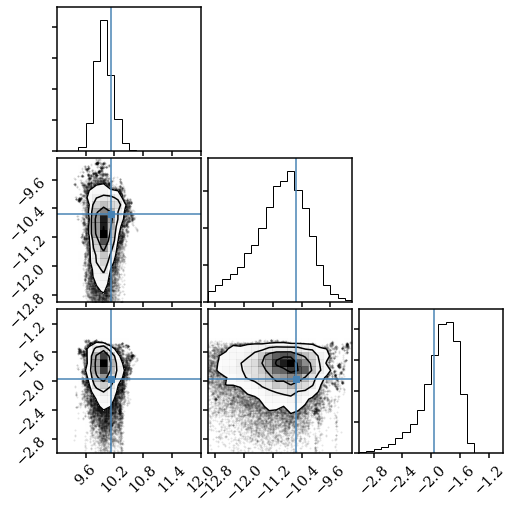

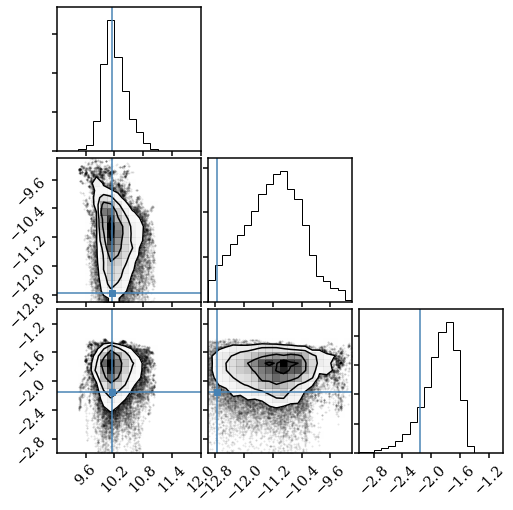

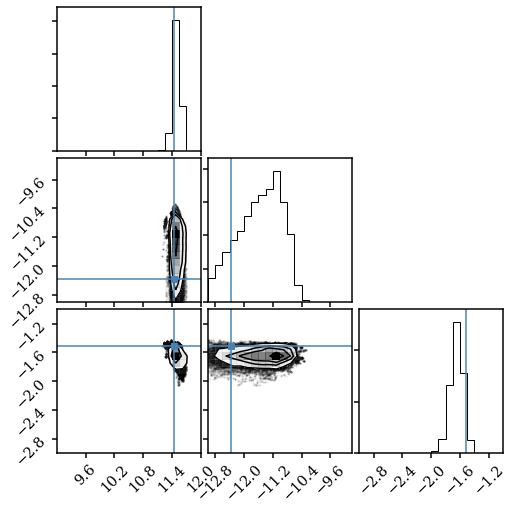

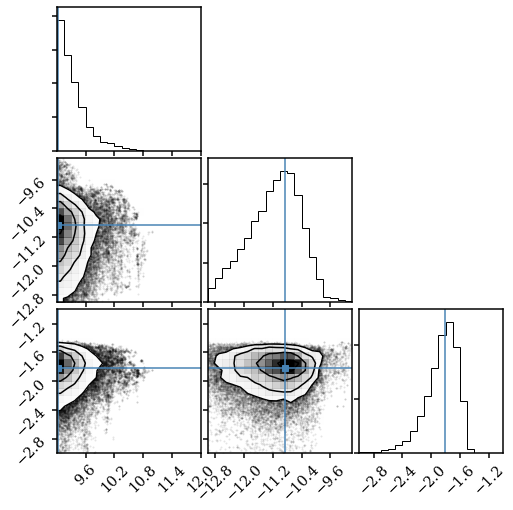

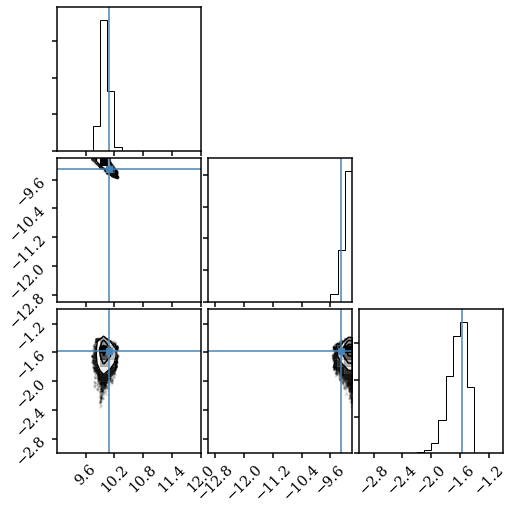

In [21]:
for i in range(5): 
    theta_deriv = np.array([logMstar_inf[i], logSSFR_inf[i], logZ_MW_inf[i]])
    theta_true = np.array([logMstar_true[i], logSSFR_true[i], logZ_MW_true[i]])
    DFM.corner(theta_deriv.T, 
               truths=theta_true, 
              range=[(9, 12), (-13, -9.), (-3., -1)])

In [26]:
# lets calculate the median, +/- sigma for each of the derived properties
logm_q = np.array([DFM.quantile(logMstar_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
logssfr_q = np.array([DFM.quantile(logSSFR_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
logzmw_q = np.array([DFM.quantile(logZ_MW_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
dust1_q = np.array([DFM.quantile(dust1_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
dust2_q = np.array([DFM.quantile(dust2_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
dust_index_q = np.array([DFM.quantile(dust_index_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])

(-2.2, 0.4)

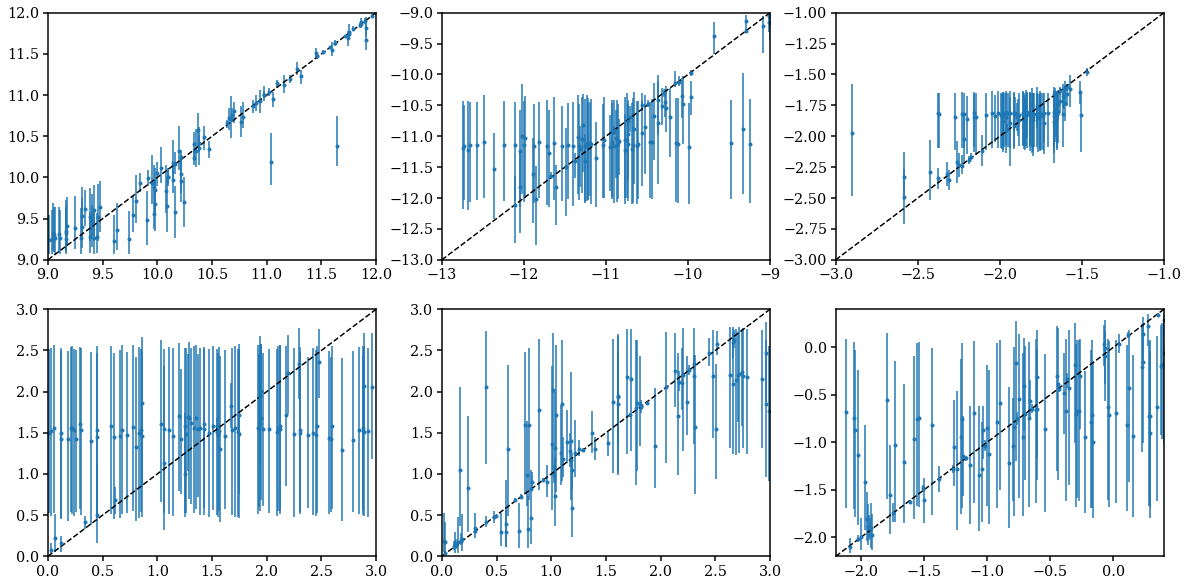

In [27]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(231)
sub.errorbar(logMstar_true, logm_q[:,1], 
             yerr=[logm_q[:,1]-logm_q[:,0], logm_q[:,2]-logm_q[:,1]],
             fmt='.C0')
sub.plot([9., 12.], [9., 12], c='k', ls='--')
sub.set_xlim(9., 12.)
sub.set_ylim(9., 12.)

sub = fig.add_subplot(232)
sub.errorbar(logSSFR_true, logssfr_q[:,1], 
             yerr=[logssfr_q[:,1]-logssfr_q[:,0], logssfr_q[:,2]-logssfr_q[:,1]], 
             fmt='.C0')
sub.plot([-9., -15.], [-9., -15], c='k', ls='--')
sub.set_xlim(-13, -9.)
sub.set_ylim(-13, -9.)

sub = fig.add_subplot(233)
sub.errorbar(logZ_MW_true, logzmw_q[:,1], 
             yerr=[logzmw_q[:,1] - logzmw_q[:,0], logzmw_q[:,2] - logzmw_q[:,1]], 
             fmt='.C0')
sub.plot([-3., -1], [-3, -1], c='k', ls='--')
sub.set_xlim(-3., -1)
sub.set_ylim(-3., -1)

sub = fig.add_subplot(234)
sub.errorbar(dust1_true, dust1_q[:,1], 
             yerr=[dust1_q[:,1] - dust1_q[:,0], dust1_q[:,2] - dust1_q[:,1]], 
             fmt='.C0')
sub.plot([prior.range[0][-3], prior.range[1][-3]], [prior.range[0][-3], prior.range[1][-3]], c='k', ls='--')
sub.set_xlim(prior.range[0][-3], prior.range[1][-3])
sub.set_ylim(prior.range[0][-3], prior.range[1][-3])

sub = fig.add_subplot(235)
sub.errorbar(dust2_true, dust2_q[:,1], 
             yerr=[dust2_q[:,1] - dust2_q[:,0], dust2_q[:,2] - dust2_q[:,1]], 
             fmt='.C0')
sub.plot([prior.range[0][-2], prior.range[1][-2]], [prior.range[0][-2], prior.range[1][-2]], c='k', ls='--')
sub.set_xlim(prior.range[0][-2], prior.range[1][-2])
sub.set_ylim(prior.range[0][-2], prior.range[1][-2])

sub = fig.add_subplot(236)
sub.errorbar(dust_index_true, dust_index_q[:,1], 
             yerr=[dust_index_q[:,1] - dust_index_q[:,0], dust_index_q[:,2] - dust_index_q[:,1]], fmt='.C0')
sub.plot([prior.range[0][-1], prior.range[1][-1]], [prior.range[0][-1], prior.range[1][-1]], c='k', ls='--')
sub.set_xlim(prior.range[0][-1], prior.range[1][-1])
sub.set_ylim(prior.range[0][-1], prior.range[1][-1])

For many of the galaxies, we essentially recover the model prior on galaxy properties. 